In [1]:
from implementations import  *
from helpers import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Loading Data

In [2]:
x_train, x_test, y_train, train_ids, test_ids = load_csv_data("data/dataset/", sub_sample=False)
assert len(y_train) == len(x_train), "Number of labels and number of rows in the dataset should be equal"

## Exploring & Preprocessing Data

In [3]:
#Get column names
column_names = np.genfromtxt("data/dataset/x_train.csv", delimiter=",", dtype=str, max_rows=1)
column_names = column_names[1:] #Remove Id column to match the number of features loaded
print(column_names[:10])

['_STATE' 'FMONTH' 'IDATE' 'IMONTH' 'IDAY' 'IYEAR' 'DISPCODE' 'SEQNO'
 '_PSU' 'CTELENUM']


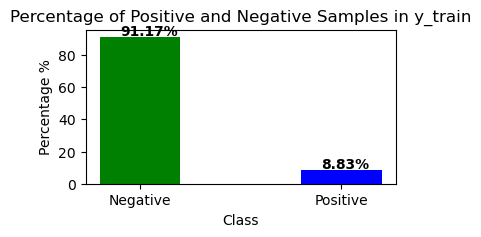

In [4]:
# calculate percentage of positive and negative samples
unique_values, counts = np.unique(y_train, return_counts=True)
percentages = counts / len(y_train) * 100

# plot bar chart
fig, ax = plt.subplots(figsize=(4, 2))
ax.bar(x=unique_values, height=percentages, color=['green', 'blue'])
ax.set_xlabel('Class')
ax.set_ylabel('Percentage %')
ax.set_title('Percentage of Positive and Negative Samples in y_train')

# add percentage values on the barplot
for i, v in zip([-1,1],percentages):
    ax.text(i-0.2, v+1, f"{v:.2f}%", color='black', fontweight='bold')

ax.set_xticks([-1, 1])
ax.set_xticklabels(['Negative', 'Positive'])
plt.show()


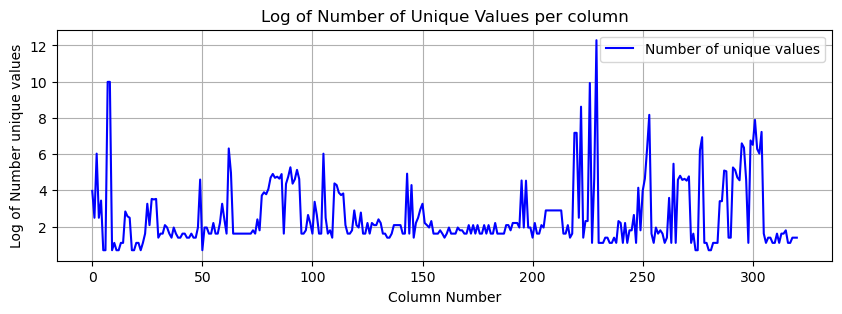

In [5]:
# Calculate the number of unique values per column
# This will give us an idea about the categorical features in the dataset

unique_values_per_col = {}
for c in range(x_train.shape[1]):
    unique_values_per_col[c] = len(np.unique(x_train[:, c]))

unique_values_per_col = {k: math.log(v) for k, v in unique_values_per_col.items()} # take log to make the plot more readable

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(list(unique_values_per_col.keys()), list(unique_values_per_col.values()), color='b', label="Number of unique values")
ax.set_xlabel("Column Number")
ax.set_ylabel("Log of Number unique values")
ax.set_title("Log of Number of Unique Values per column")
ax.legend()
ax.grid()
plt.show()

In [6]:
# Calculate the percentage of columns with less than 12 unique values
lss = []
for c in range(x_train.shape[1]):
    lss.append( len(np.unique(x_train[:, c])) )
    percentage = sum(1 for x in lss if x < 6) / len(lss) * 100

print( f"{sum(1 for x in lss if x <= 12) / len(lss) * 100: 0.2f}% of columns have 12 or less unique values.")

 70.09% of columns have 12 or less unique values.


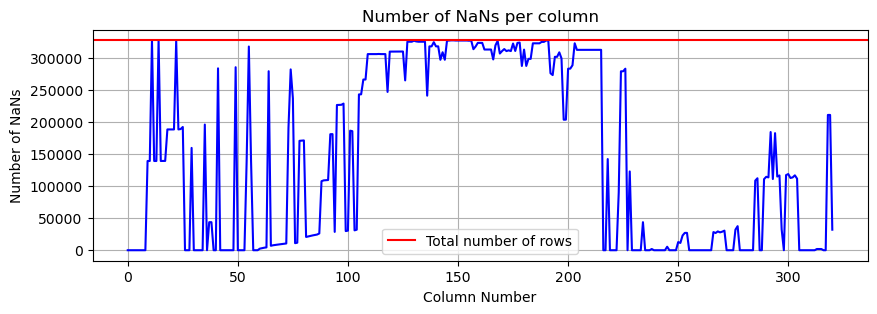

In [7]:
# Exploring & Handling NaN Value
nan_counts = np.isnan(x_train).sum(axis=0)
#nan_test_counts = np.isnan(x_test).sum(axis=0)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.arange(len(nan_counts)), nan_counts,c='b')
#ax.plot(np.arange(len(nan_test_counts)), nan_test_counts, c='r')

ax.axhline(y=len(x_train), color='r', linestyle='-', label="Total number of rows")
ax.set_xlabel("Column Number")
ax.set_ylabel("Number of NaNs")
ax.set_title("Number of NaNs per column")
ax.legend()
ax.grid()
plt.show()

We notice a lot of NAN values and especially some very close to the number of input rows.

In [8]:
# Handling NaN values
# We will remove columns with more than 1/3% of NaNs
columns_to_remove = np.where(nan_counts > len(x_train) / 3)[0]

print(f"{len(columns_to_remove)} Columns have more than 1/3% NaNs   ")

data_cleaned = np.delete(x_train, columns_to_remove, axis=1)
x_test_cleaned = np.delete(x_test, columns_to_remove, axis=1)

columns_clean = np.delete(column_names, columns_to_remove)

174 Columns have more than 1/3% NaNs   


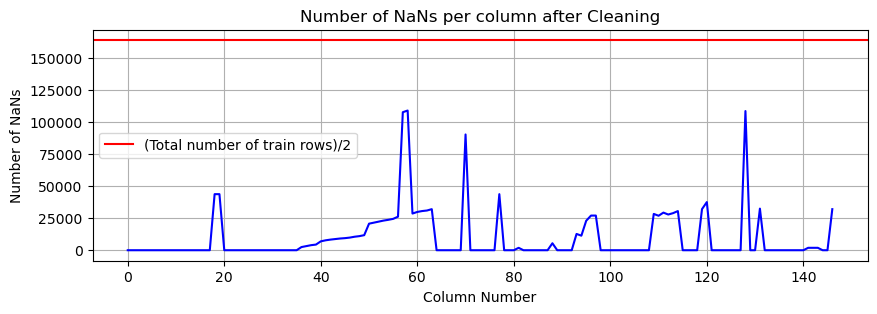

In [9]:
nan_cleaned_counts = np.isnan(data_cleaned).sum(axis=0)

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(np.arange(len(nan_cleaned_counts)), nan_cleaned_counts,c='b')

ax.axhline(y=len(data_cleaned)/2, color='r', linestyle='-', label="(Total number of train rows)/2")
ax.set_xlabel("Column Number")
ax.set_ylabel("Number of NaNs")
ax.set_title("Number of NaNs per column after Cleaning")
ax.legend()
ax.grid()
plt.show()

In [10]:
#Handling Nan Values
# Replacing NaN with Median Values 
# More robust to Outliers & conform to categorical features

medians = np.nanmedian(data_cleaned, axis=0)
means = np.nanmean(data_cleaned, axis=0) # we will use this later
stds = np.nanstd(data_cleaned, axis=0) # we will use this later

data_cleaned[np.isnan(data_cleaned)] = np.take(medians, np.isnan(data_cleaned).nonzero()[1])
assert np.isnan(data_cleaned).sum() == 0, "There should be no NaNs in the dataset"

In [11]:
#Exploring & Handling outliers
#Using Z-Score

z_scores = np.abs((data_cleaned - means) / stds) 
z_scores[np.isnan(z_scores)] = 0 # replace nan values with 0 z score because there is no variation 
indices = np.where((z_scores < 5).all(axis=1))[0]  # Identify and isolate data points with z-score > 5

z_scores_5 = z_scores[indices]
print(f"Percentage of total outliers with z_score > 5 from whole dataset : {(1-(len(z_scores_5)/len(z_scores)))*100:0.2f}%")

outliers_y = y_train[~np.isin(np.arange(len(y_train)), indices)]
print(f"Percentage of positive outlier samples from total positive samples: {(len(outliers_y[outliers_y == 1])/len(y_train[y_train == 1]))*100:0.2f}%")
print(f"Percentage of negative outlier samples from total negative samples: {(len(outliers_y[outliers_y == -1])/len(y_train[y_train == -1]))*100:0.2f}%")

Percentage of total outliers with z_score > 5 from whole dataset : 24.09%
Percentage of positive outlier samples from total positive samples: 24.81%
Percentage of negative outlier samples from total negative samples: 24.02%


Around 25% of the positive labels can be identified as outliers using z-score. However, since we are dealing with a huge data imbalance, we chose not to use this technique because it will generate more imbalance.

In [15]:
# Using Interquartile Range
# remove rows with at least third the columns representing outlier features

iq_1 = np.quantile(data_cleaned, 0.2, axis=0)
iq_3 = np.quantile(data_cleaned, 0.8, axis=0)

outlier_count = np.sum((data_cleaned < iq_1) | (data_cleaned > iq_3), axis=1)
indices = np.where(outlier_count >= data_cleaned.shape[1]/3)[0] 
outliers_y = y_train[indices]

print(f"Percentage of total rows with at least third features representing outliers from whole dataset : {(len(indices)/len(data_cleaned))*100:0.2f}%")
print( f"Percentage of negative values from the outliers {len(outliers_y[outliers_y == 1])/len(outliers_y)*100:0.2f}%" )
print(f"Percentage of positive outlier samples from total positive samples: {(len(outliers_y[outliers_y == 1])/len(y_train[y_train == 1]))*100:0.2f}%")
print(f"Percentage of negative outlier samples from total negative samples: {(len(outliers_y[outliers_y == -1])/len(y_train[y_train == -1]))*100:0.2f}%")

Percentage of total rows with at least third features representing outliers from whole dataset : 2.05%
Percentage of negative values from the outliers 12.38%
Percentage of positive outlier samples from total positive samples: 2.87%
Percentage of negative outlier samples from total negative samples: 1.97%


We can assume that this method is safer to use since we are only deleting less than 3% of the positive samples as compared to 25% using z-scores.

In [16]:
data_cleaned = np.delete(data_cleaned, indices, axis=0)
y_train = np.delete(y_train, indices, axis=0)

## Feature Selection & Engineering 

### Features Correlation

In [17]:
### Removing Highly Inter-correlated Features
data_cleaned, columns_to_keep, highly_correlated_cols = remove_highly_correlated_columns(data_cleaned, y_train ,threshold=0.8)

names_tobe_removed = columns_clean[highly_correlated_cols]
indices_to_remove = np.where(np.isin(column_names, names_tobe_removed))[0]
columns_to_remove = list(set(np.concatenate((columns_to_remove, indices_to_remove))))

columns_clean = columns_clean[columns_to_keep]

/var/folders/xc/fqhfbxxx7yb4n__mj0cc0wvc0000gn/T/ipykernel_77372/503917807.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( x_labels, rotation=45,size=15)


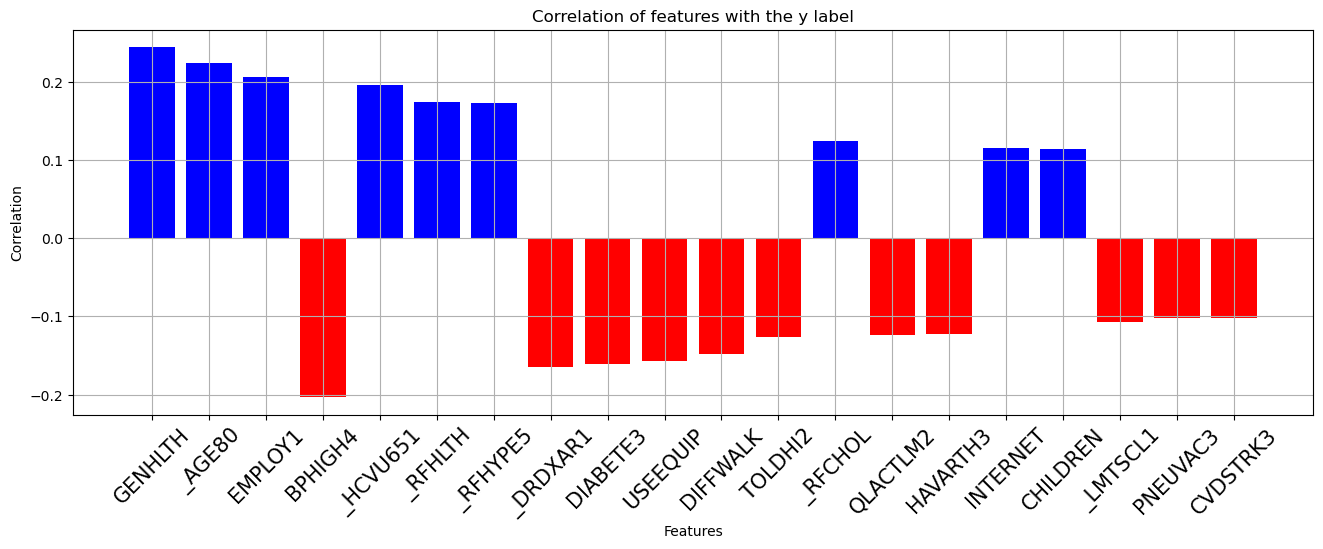

In [18]:
# Observe the correlation of features with the y label
assert np.isnan(data_cleaned).sum() == 0, "There should be no NaNs in the dataset"
assert data_cleaned.shape[0] == data_cleaned.shape[0], "Number of labels and number of rows in the dataset should be equal but found {} and {}".format(data_cleaned.shape[0], y_train.shape[0])

corr = np.corrcoef(data_cleaned.T, y_train)
corr_to_y = corr[-1, :-1]
sorted_indices = np.argsort(np.abs(corr_to_y))[::-1]
sorted_features = columns_clean[sorted_indices]
sorted_corr = corr_to_y[sorted_indices]

#Plot the correlation
fig, ax = plt.subplots(figsize=(16, 5))
x_labels = []
for feature, corr in zip(sorted_features, sorted_corr):
    if abs(corr) > 0.1 :
        ax.bar(feature, corr, color='b' if corr > 0 else 'r')
        x_labels.append(feature)

ax.set_xticklabels( x_labels, rotation=45,size=15)
ax.set_ylabel("Correlation")
ax.set_xlabel("Features")
ax.set_title("Correlation of features with the y label")
ax.grid()
plt.show()

In [19]:
# # Let's look at the top 10 features with the highest correlation with the y label in raw data and cleaned data
# print("Top 40 features with the highest correlation with the y label in data\n", sorted_features[:40])

In [20]:
#Remove features with low correlation (less than threshold=0.05) with the y label
corr_threshold = 0.05
corr_mask = np.abs(corr_to_y) > corr_threshold

data_cleaned = data_cleaned[:, corr_mask]

names_tobe_removed = columns_clean[~corr_mask]
indices_to_remove = np.where(np.isin(column_names, names_tobe_removed))[0]
columns_to_remove = list(set(np.concatenate((columns_to_remove, indices_to_remove))))

columns_clean = columns_clean[corr_mask]

In [21]:
# Filter only the top 40 features with the highest correlation with the y label
# Separate categorical and non-categorical features in different lists

relevant_cat_features= [] # categorical features
relevant_non_cat_features = [] # non-categorical features

for feature in sorted_features[:40]:
    column_idx = column_names.tolist().index(feature)
    values = np.unique(x_train[:,column_idx])
    if len(values) <= 8:
        relevant_cat_features.append(feature)
    else:
        relevant_non_cat_features.append(feature)

In [22]:
print("Relevant non categorical features: \n", relevant_non_cat_features)
print("\nRelevant categorical features: \n",relevant_cat_features)

Relevant non categorical features: 
 ['_AGE80', 'EMPLOY1', 'CHILDREN', 'PHYSHLTH', 'ALCDAY5', 'STRENGTH']

Relevant categorical features: 
 ['GENHLTH', 'BPHIGH4', '_HCVU651', '_RFHLTH', '_RFHYPE5', '_DRDXAR1', 'DIABETE3', 'USEEQUIP', 'DIFFWALK', 'TOLDHI2', '_RFCHOL', 'QLACTLM2', 'HAVARTH3', 'INTERNET', '_LMTSCL1', 'PNEUVAC3', 'CVDSTRK3', 'VETERAN3', '_CHLDCNT', 'CHCCOPD1', 'SMOKE100', 'EDUCA', '_CHISPNC', 'QSTVER', 'DIFFALON', 'DIFFDRES', 'SEX', 'EXERANY2', 'FLUSHOT6', 'CHCOCNCR', '_BMI5CAT', 'CHOLCHK', 'CHCSCNCR', '_SMOKER3']


### One-hot encoding for categorized columns & Feature Expansion

In [23]:
x_train1 = data_cleaned.copy() # make a copy of the cleaned data

In [24]:
#expand matrix by one hot encoding
x_train1 = one_hot_encoder(x_train1, columns_clean, relevant_cat_features) #one hot encoding
x_train1 = concat_features(data_cleaned, x_train1, relevant_non_cat_features, columns_clean) #concatenate non categorical features with categorical features

#Splitting the data into training and testing data
ratio = 0.8 # 80% of trainnig data is used for training
seed = 1 # random seed
x_train_split, x_test_split , y_train_split, y_test_split = train_test_split(x_train1, y_train, test_size=1-ratio, random_state=seed)

### Oversampling & Undersampling the training data

In [25]:
#SMOTE Oversampling
x_train_split , y_train_split = SMOTE(x_train_split, y_train_split, k=5,ratio=0.85) # was 0.5

  0%|          | 0/19088 [00:00<?, ?it/s]

100%|██████████| 19088/19088 [02:44<00:00, 115.83it/s]


In [26]:
x_oversampled , y_oversampled = x_train_split.copy(), y_train_split.copy() # make a copy of the oversampled data to try different hyperparameters later

In [27]:
#Undersampling
x_train_split , y_train_split = undersample_majority(x_train_split, y_train_split,ratio=4) #was 0.85
x_train_split, x_mean , x_std = standardize(x_train_split)

In [28]:
#Feature Expansion
#Selected interactions are the interactions (i,j) that have been selected by the feature expansion function

x_train_split, selected_interactions = feature_expansion(x_train_split, y_train_split,desired_number_of_features=130) #180

## Training & Testing the ML models

In [68]:
#Setting up parameters
seed = 0 # Random seed for determinisitc results
gamma = 0.001 # Learning rate 0.001
max_iters = 10000 # Maximum number of iterations 20000
_lambda = 0.01 # Regularization parameter 0.01

#Prepping data for training
y , tx = build_model_data( y_train_split,x_train_split)

In [74]:
y[y==-1] = 0 # replace -1 with 0 

w = np.random.normal(0, 0.1, tx.shape[1])

#weights = np.unique(y, return_counts=True)[1]*[1,2]/len(y)
#w1,loss1 = weighted_reg_logistic_regression(y, tx, _lambda, w, max_iters, gamma, weights)

#w2,loss1 = logistic_regression(y, tx, w, max_iters, gamma)
w,loss = reg_logistic_regression(y, tx, _lambda, w, max_iters, gamma)
#w1,loss = ridge_regression(y, tx, _lambda)
#w,loss = least_squares(y, tx)
#w,loss = mean_squared_error_gd(y, tx, w, max_iters, gamma)

Current iteration=0, loss=1.1838737698522497 (with regularization)
Current iteration=100, loss=0.8842048077108183 (with regularization)
Current iteration=200, loss=0.7132030129384686 (with regularization)
Current iteration=300, loss=0.622587742495328 (with regularization)
Current iteration=400, loss=0.5694606674891958 (with regularization)
Current iteration=500, loss=0.5348824227764245 (with regularization)
Current iteration=600, loss=0.5105229979991661 (with regularization)
Current iteration=700, loss=0.4922988597829966 (with regularization)
Current iteration=800, loss=0.4780454707015073 (with regularization)
Current iteration=900, loss=0.4665303625943362 (with regularization)
Current iteration=1000, loss=0.45700233317048317 (with regularization)
Current iteration=1100, loss=0.44897420983555697 (with regularization)
Current iteration=1200, loss=0.44211270983042333 (with regularization)
Current iteration=1300, loss=0.43617961871743544 (with regularization)
Current iteration=1400, loss=

In [77]:

pred_train = predict(tx, w) #predict outputs values in -1,1

tx_test = (x_test_split - x_mean) / x_std #standardize test data with train mean and std

#The next two lines perform feature expansion
selected_interaction_terms = np.column_stack([tx_test[:, i] * tx_test[:, j] for i, j in selected_interactions])
tx_test = np.column_stack((tx_test, selected_interaction_terms))

tx_test = np.c_[np.ones((tx_test.shape[0], 1)), tx_test] #add bias term

pred_test = predict(tx_test, w)

y_test_split[y_test_split==0] = -1    # Reconvert labels to -1,1
y_train_split[y_train_split==0] = -1  # Reconvert labels to -1,1

# Print accuracy, recall, precision, and f1 score for train set
print("Train set:")
print_results(y_train_split, pred_train)

# Print accuracy, recall, precision, and f1 score for test set
print("\nTest set:")
print_results(y_test_split, pred_test)


Train set:
Accuracy:  0.8402358887952822
Recall:  0.38972198820556025
Precision:  0.673951048951049
F1 score:  0.4938614284189175
Confusion Matrix: 
 [[158347   7833]
 [ 25354  16191]]

Test set:
Accuracy:  0.8969556492385234
Recall:  0.3406612733028491
Precision:  0.40253532834580213
F1 score:  0.36902267098494945
Confusion Matrix: 
 [[55722  2875]
 [ 3749  1937]]


In [50]:
#Preparing test data
x_test1 = x_test.copy()
x_test1 = prepare_data(x_test1, columns_to_remove) #clean data

x_test_hot = one_hot_encoder(x_test1, columns_clean, relevant_cat_features) #one hot encoding
x_test1 = concat_features(x_test1, x_test_hot, relevant_non_cat_features, columns_clean) #concatenate non categorical features with categorical features

x_test1 = (x_test1 - x_mean) / x_std #standardize test data

#The next two lines perform feature expansion on the test data
selected_interaction_terms = np.column_stack([x_test1[:, i] * x_test1[:, j] for i, j in selected_interactions])
x_test1 = np.column_stack((x_test1, selected_interaction_terms))


x_test1  = np.c_[np.ones(x_test1.shape[0]), x_test1] #add bias term
pred_test = predict(x_test1, w, threshold=0.58)

create_csv_submission(test_ids, pred_test, "submission_ai.csv")

In [254]:
# # Divide the dataset into subsets based on the value of the first feature

# ratio = 0.9 # 90% of data is used for training
# seed = 1 # Random seed
# gamma = 0.001 # Learning rate
# max_iters = 10000 # Maximum number of iterations
# _lambda = 0.01 # Regularization parameter

# y , tx = build_model_data(y_train1, x_train1)
# tx_train, tx_test, yb_train, yb_test = train_test_split(tx, y, test_size=1-ratio, random_state=seed)
# y[y==-1] = 0    
# unique_values = np.unique(x_train1[:, 0])
# w = np.random.normal(0, 0.1, tx_train.shape[1])
# models = {}
# for value in unique_values:
#     print("Training model for value: ", value)
#     indices = np.where(tx_train[:, 1] == value)[0]
#     print(len(indices))
#     y_filtered = yb_train[indices]
#     x_filtered = tx_train[indices]
#     weights = np.bincount(y_filtered)/len(y_filtered)
#     w, loss = weighted_reg_logistic_regression(y_filtered, x_filtered, _lambda, w, max_iters, gamma, weights)
#     models[value] = (w, loss)
# # Predict the labels for the test set
# yb_test[yb_test==0] = -1
# yb_train[yb_train==0] = -1

# pred_test = np.zeros(yb_test.shape)
# for i, sample in enumerate(tx_test):
#     value = sample[0]
#     model = models[value][0]
#     pred = predict(sample.reshape(1, -1), model)
#     pred_test[i] = pred

# pred_train = np.zeros(yb_train.shape)
# for i, sample in enumerate(tx_train):
#     value = sample[0]
#     model,loss = models[value]
#     if loss is not None:
#         pred_train[i] = predict(sample.reshape(1, -1), model)
#     else:
#         pred_train[i] = model


# # Print accuracy, recall, precision, and f1 score for train set
# print("Train set:")
# print_results(yb_train, pred_train)


# # Print accuracy, recall, precision, and f1 score for test set
# print("\nTest set:")
# print_results(yb_test, pred_test)